In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
# seed_constant = 27
# np.random.seed(seed_constant)
# random.seed(seed_constant)
# tf.random.set_seed(seed_constant)

In [8]:
# Specify the height and width of the images.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames (images) in a sequence.
SEQUENCE_LENGTH = 15

# Specify the directory containing your dataset of images.
DATASET_DIR = "E:/Anamoly Detection"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.


In [9]:
def load_images(class_name):
    images_list = []
    class_dir = os.path.join(DATASET_DIR, class_name)
    image_files = os.listdir(class_dir)
    image_files.sort()

    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_image = resized_image / 255.0
        images_list.append(normalized_image)

    return images_list

In [10]:
def create_dataset():
    features = []
    labels = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Loading data for class: {class_name}')
        images = load_images(class_name)

        for i in range(0, len(images) - SEQUENCE_LENGTH + 1, SEQUENCE_LENGTH):
            sequence = images[i:i+SEQUENCE_LENGTH]
            features.append(sequence)
            labels.append(class_index)
    np.save('features.npy', features)
    np.save('labels.npy' , labels)

    return np.array(features), np.array(labels)


In [11]:
features, labels = create_dataset()

Loading data for class: Abuse
Loading data for class: Arrest
Loading data for class: Explosion
Loading data for class: Fighting
Loading data for class: RoadAccidents
Loading data for class: Robbery
Loading data for class: Shooting
Loading data for class: Stealing


In [12]:
features.shape, labels.shape
labels

array([0, 0, 0, ..., 7, 7, 7])

In [13]:
one_hot_encoded_labels = to_categorical(labels)

In [14]:
one_hot_encoded_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [15]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=42)

In [16]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [17]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 4, 4, 32)     0

In [18]:
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

In [19]:
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(
    x=features_train, y=labels_train, epochs=50, batch_size=16,
    shuffle=True, validation_split=0.2)

Epoch 1/50
576/576 [==============================] - 246s 389ms/step - loss: 1.7261 - accuracy: 0.3694 - val_loss: 1.3264 - val_accuracy: 0.5462
Epoch 2/50
576/576 [==============================] - 120s 208ms/step - loss: 1.1292 - accuracy: 0.6143 - val_loss: 0.9083 - val_accuracy: 0.6874
Epoch 3/50
576/576 [==============================] - 118s 205ms/step - loss: 0.7291 - accuracy: 0.7602 - val_loss: 0.5534 - val_accuracy: 0.8281
Epoch 4/50
576/576 [==============================] - 118s 205ms/step - loss: 0.4797 - accuracy: 0.8500 - val_loss: 0.3982 - val_accuracy: 0.8819
Epoch 5/50
576/576 [==============================] - 118s 206ms/step - loss: 0.3378 - accuracy: 0.8985 - val_loss: 0.3224 - val_accuracy: 0.9053
Epoch 6/50
576/576 [==============================] - 120s 208ms/step - loss: 0.2593 - accuracy: 0.9211 - val_loss: 0.2828 - val_accuracy: 0.9110
Epoch 7/50
576/576 [==============================] - 118s 205ms/step - loss: 0.2004 - accuracy: 0.9406 - val_loss: 0.2903 -

In [20]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

120/120 [==============================] - 15s 122ms/step - loss: 0.0769 - accuracy: 0.9828


In [21]:
# Save the trained model
LRCN_model.save("LSTM.h5")
print("Model saved as LSTM.h5")

Model saved as LSTM.h5


In [22]:
# Define function to plot metrics
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()


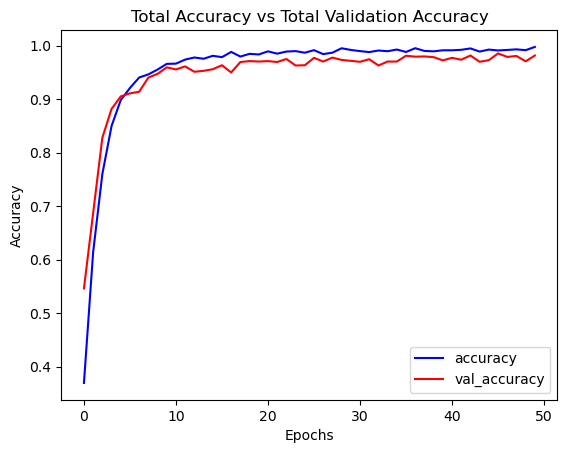

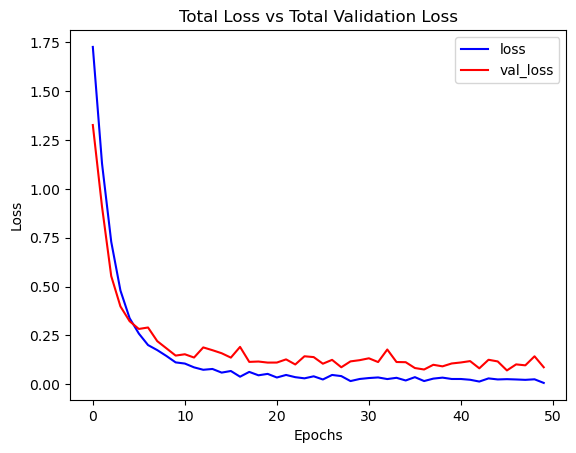

In [24]:
# Plot accuracy and validation accuracy metrics
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.savefig('ACCURACY1.PNG')
plt.show()

# Plot loss and validation loss metrics
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('Loss1.png')
plt.show()